In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd /content/drive/MyDrive/ml-project
!ls

/content/drive/.shortcut-targets-by-id/1EYMdZLRTdcPuJ5_rIIaX4w-t7oZvIr0-/ml-project
'Accident Severity Prediction.gslides'	      nn-model-epoch-200.pt
 dvc					      nn-model-epoch-250.pt
'Exploratory Data Analysis - Group 14.gdoc'   nn-model-epoch-300.pt
 ml-project				      nn-model-epoch-350.pt
'ML Project .gdoc'			      nn-model-epoch-50.pt
 ml-project.zip				      testing_data.csv
'ML Report.gdoc'			      traning_data.csv
 nn-model-epoch-0.pt			      y_test.npy
 nn-model-epoch-100.pt			      y_train.npy
 nn-model-epoch-150.pt


In [ ]:

%cd /content/drive/MyDrive/ml/ml-project
!ls

/content/drive/MyDrive/ml/ml-project
'Accident Severity Prediction.gslides'	      nn-model-epoch-200.pt
 dvc					      nn-model-epoch-250.pickle
'Exploratory Data Analysis - Group 14.gdoc'   nn-model-epoch-250.pt
 ml-project				      nn-model-epoch-300.pickle
'ML Project .gdoc'			      nn-model-epoch-300.pt
 ml-project.zip				      nn-model-epoch-350.pt
'ML Report.gdoc'			      nn-model-epoch-50.pickle
 nn-model-epoch-0.pickle		      nn-model-epoch-50.pt
 nn-model-epoch-0.pt			      testing_data.csv
 nn-model-epoch-100.pickle		      tmp.pickle
 nn-model-epoch-100.pt			      traning_data.csv
 nn-model-epoch-150.pickle		      y_test.npy
 nn-model-epoch-150.pt			      y_train.npy
 nn-model-epoch-200.pickle


In [ ]:

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
from torch.utils.data import Dataset
from torch.utils.data import DataLoader, random_split

import torchvision.transforms as transforms
import torchvision.datasets as datasets

import matplotlib.pyplot as plt
import numpy as np

import copy
import random
import time

import pandas as pd
import os
# imports pytorch
import torch
import pickle


# imports the torch_xla package
# import torch_xla
# import torch_xla.core.xla_model as xm


In [ ]:
class us_dataset(Dataset):
	"""
	Dataloader class for loading the training and testing data of q3
	"""
	def __init__(self,train = True):
		if train:        
			self.X = pd.read_csv("traning_data.csv").values
			self.y = np.load("y_train.npy") - 1
		else:
			self.X = pd.read_csv("testing_data.csv").values
			self.y = np.load("y_test.npy") - 1
		
	def __len__(self):
		return self.X.shape[0]

	def __getitem__(self, idx):
		return self.X[idx],self.y[idx]

class MLP(nn.Module):
	def __init__(self, input_dim, output_dim):
		super().__init__()
			
		# self.input_fc = nn.Linear(input_dim, 512)
		self.input_fc = nn.Linear(input_dim, 32)
		#torch.nn.init.normal_(self.input_fc.weight)

		# self.hidden_1 = nn.Linear(512, 256)
		self.hidden_1 = nn.Linear(32, 32)
		#torch.nn.init.normal_(self.hidden_1.weight)

		self.hidden_2 = nn.Linear(32, 16)

		self.hidden_3 = nn.Linear(16, 16)

		# self.output_fc = nn.Linear(256, output_dim)
		self.losses = []
		self.output_fc = nn.Linear(16, output_dim)
		#torch.nn.init.normal_(self.output_fc.weight)

		
	def forward(self, x):
		batch_size = x.shape[0]
		x = x.view(batch_size, -1)
		h_1 = F.relu(self.input_fc(x))
		h_2 = F.relu(self.hidden_1(h_1))
		h_3 = F.relu(self.hidden_2(h_2))
		h_4 = F.relu(self.hidden_3(h_3))
		y_pred = self.output_fc(h_3)

		return y_pred, h_1

def calculate_accuracy(y_pred, y):
	"""
		Function for calculating the accuracy of the predictied values 
	"""
	top_pred = y_pred.argmax(1, keepdim = True)
	correct = top_pred.eq(y.view_as(top_pred)).sum()
	acc = correct.float() / y.shape[0]
	return acc

def train(model, iterator, optimizer, criterion, device):
	
	epoch_loss = 0
	epoch_acc = 0
	
	model.train()
	
	for (x, y) in iterator:
		
		x = x.to(device)
		y = y.to(device)
		
		optimizer.zero_grad()
				
		y_pred, _ = model(x.float())
		
		loss = criterion(y_pred, y.long())
		
		acc = calculate_accuracy(y_pred, y)
		
		loss.backward()
		
		optimizer.step()
		
		epoch_loss += loss.item()
		epoch_acc += acc.item()
		
	return epoch_loss / len(iterator), epoch_acc / len(iterator)

def evaluate(model, iterator, criterion, device):
	
	epoch_loss = 0
	epoch_acc = 0
	
	model.eval()
	
	with torch.no_grad():
		
		for (x, y) in iterator:

			x = x.to(device)
			y = y.to(device)

			y_pred, _ = model(x.float())

			loss = criterion(y_pred, y.long())

			acc = calculate_accuracy(y_pred, y)

			epoch_loss += loss.item()
			epoch_acc += acc.item()
		
	return epoch_loss / len(iterator), epoch_acc / len(iterator)

def epoch_time(start_time, end_time):
	"""
	Helper function for calculating the time required for one epoch
 
	"""
	elapsed_time = end_time - start_time
	elapsed_mins = int(elapsed_time / 60)
	elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
	return elapsed_mins, elapsed_secs


In [ ]:
train_dataset1 = us_dataset()
test_dataset1 = us_dataset(False)

trainset1, valset1 = random_split(train_dataset1, [2159442, 239938])

BATCH_SIZE = 512

#divide the data into batches
train_iterator1 = DataLoader(trainset1, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
valid_iterator1 = DataLoader(valset1, batch_size=BATCH_SIZE, num_workers=4)
test_iterator1 = DataLoader(test_dataset1, batch_size=BATCH_SIZE, num_workers=4)

INPUT_DIM = 37
OUTPUT_DIM = 4

# define he model 
model = MLP(INPUT_DIM, OUTPUT_DIM)

optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()
device = torch.device('cuda') # if torch.cuda.is_available() else 'cpu')
model = model.to(device)
criterion = criterion.to(device)


EPOCHS = 1000

best_valid_loss = float('inf')



In [ ]:
#training loop

# train_loss = [0]*EPOCHS
# train_acc = [0]*EPOCHS
# valid_loss = [0]*EPOCHS
# valid_acc = [0]*EPOCHS

for epoch in range(EPOCHS):

    start_time = time.monotonic()

    #one epoch
    train_loss, train_acc = train(model, train_iterator1, optimizer, criterion, device)
    valid_loss, valid_acc = evaluate(model, valid_iterator1, criterion, device)
    model.losses.append({'epoch' : epoch,
                         'train_loss' : train_loss,
                         'train_acc' : train_acc,
                         'valid_loss' : valid_loss,
                         'valid_acc' : valid_acc})
    if epoch % 50 == 0 or epoch == EPOCHS - 1:
        #torch.save(model.state_dict(), f'nn-model-epoch-{epoch}.pt')
        pickle.dump(model,open(f'nn-model-epoch-{epoch}.pickle',"wb"))

    end_time = time.monotonic()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')


In [ ]:
model.load_state_dict(torch.load('nn-model-epoch-150.pt'))

<All keys matched successfully>

In [ ]:
model.losses

[]

In [ ]:

pickle.dump(model,open("tmp.pickle","wb"))

In [ ]:
model = pickle.load(open("nn-model-epoch-300.pickle","rb"))

In [ ]:
train_dataset1 = us_dataset()
test_dataset1 = us_dataset(False)

trainset1, valset1 = random_split(train_dataset1, [2159442, 239938])

BATCH_SIZE = 512

#divide the data into batches
train_iterator1 = DataLoader(trainset1, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
valid_iterator1 = DataLoader(valset1, batch_size=BATCH_SIZE, num_workers=4)
test_iterator1 = DataLoader(test_dataset1, batch_size=BATCH_SIZE, num_workers=4)


In [ ]:
def my_test(model,iterator,device):
    model.eval()
    output = []    
    tru = []
    with torch.no_grad():
      
      for (x, y) in iterator:

        x = x.to(device)
        y = y.to(device)

        y_pred, _ = model(x.float())
        output.extend(y_pred)
        tru.extend(y)
    return output, tru


In [ ]:
output, tru = my_test(model,test_iterator1,device = torch.device('cuda'))

In [ ]:
len(output), len(tru)

(1028307, 1028307)

In [ ]:
output[0].argmax(), tru[0].cpu().numpy()

(tensor(1, device='cuda:0'), array(2))

In [ ]:
from tqdm import tqdm
out = []
j = []
for i in tqdm(output):
  out.append(i.argmax().cpu().numpy())

for i in tqdm(tru):
  j.append(i.cpu().numpy())

100%|██████████| 1028307/1028307 [00:19<00:00, 53424.00it/s]


In [ ]:
from sklearn.metrics import classification_report

print(classification_report(j, out))

              precision    recall  f1-score   support

           0       0.59      0.22      0.32      8581
           1       0.74      0.89      0.81    695600
           2       0.57      0.34      0.42    291575
           3       0.53      0.24      0.33     32551

    accuracy                           0.71   1028307
   macro avg       0.61      0.42      0.47   1028307
weighted avg       0.69      0.71      0.68   1028307



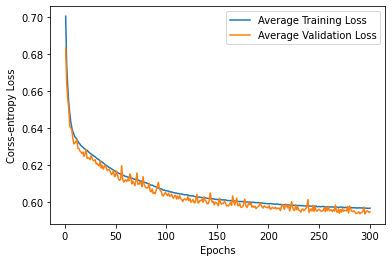

In [ ]:
epoch_ans = [i for i in range(1,301)]
train_loss_ans = [i['train_loss'] for i in model.losses]
test_loss_ans = [i['valid_loss'] for i in model.losses]

plt.plot(epoch_ans, train_loss_ans[:-2], label = "Average Training Loss")
plt.plot(epoch_ans, test_loss_ans[:-2], label = "Average Validation Loss")
plt.xlabel('Epochs')
plt.ylabel("Corss-entropy Loss")
plt.legend(loc='best')
plt.savefig(f"neural_net_loss_plot.png")
plt.show()

In [ ]:
criterion = nn.CrossEntropyLoss()
device = torch.device('cuda') # if torch.cuda.is_available() else 'cpu')

evaluate(model, test_iterator1, criterion, device)

(0.5976780806387639, 0.710149438242345)

In [ ]:
pip install kmeanstf

In [ ]:
from kmeanstf import KMeansTF
import pandas as pd
import numpy as np

In [ ]:
X = pd.read_csv("traning_data.csv").values
y = np.load("y_train.npy")
		

In [ ]:

km = KMeansTF(n_clusters=10, random_state=1234, verbose = 1, max_iter = 1000, tol = 1e-16)
km.fit(X[y == 2])


_k_means(): k-means init #0, init=k-means++  tolerance reached at Lloyd iter 27 SSE=3400934.25000: 0.00000E+00 < 8.35003E-18 (tol)
 k-means SSE: 3400934.25000

_k_means(): k-means init #1, init=k-means++  tolerance reached at Lloyd iter 40 SSE=3395004.25000: 0.00000E+00 < 8.35003E-18 (tol)
 k-means SSE: 3395004.25000

_k_means(): k-means init #2, init=k-means++  tolerance reached at Lloyd iter 26 SSE=3322534.25000: 0.00000E+00 < 8.35003E-18 (tol)
 k-means SSE: 3322534.25000

_k_means(): k-means init #3, init=k-means++  tolerance reached at Lloyd iter 30 SSE=3394549.75000: 0.00000E+00 < 8.35003E-18 (tol)
 k-means SSE: 3394549.75000

_k_means(): k-means init #4, init=k-means++  tolerance reached at Lloyd iter 29 SSE=3319467.25000: 0.00000E+00 < 8.35003E-18 (tol)
 k-means SSE: 3319467.25000

_k_means(): k-means init #5, init=k-means++  tolerance reached at Lloyd iter 118 SSE=3372975.00000: 0.00000E+00 < 8.35003E-18 (tol)
 k-means SSE: 3372975.00000

_k_means(): k-means init #6, init=k-me

In [ ]:
from sklearn.cluster import KMeans

In [ ]:

Sum_of_squared_distances = []
for k in range(2,16):
    print(f"k = {k}")
    km = KMeans(n_clusters=k,verbose=1, max_iter = 1000)
    km = km.fit(X[y == 2])
    Sum_of_squared_distances.append(km.inertia_)

k = 2
Initialization complete
start iteration
done sorting
end inner loop
Iteration 0, inertia 4725228.472743185
start iteration
done sorting
end inner loop
Iteration 1, inertia 4658869.718917232
start iteration
done sorting
end inner loop
Iteration 2, inertia 4588488.025630801
start iteration
done sorting
end inner loop
Iteration 3, inertia 4534352.596792191
start iteration
done sorting
end inner loop
Iteration 4, inertia 4519484.449294041
start iteration
done sorting
end inner loop
Iteration 5, inertia 4519484.449294041
center shift 0.000000e+00 within tolerance 8.350048e-06
Initialization complete
start iteration
done sorting
end inner loop
Iteration 0, inertia 4753747.497093017
start iteration
done sorting
end inner loop
Iteration 1, inertia 4692734.184277119
start iteration
done sorting
end inner loop
Iteration 2, inertia 4658696.773426725
start iteration
done sorting
end inner loop
Iteration 3, inertia 4635976.897925456
start iteration
done sorting
end inner loop
Iteration 4, ine

In [ ]:
km.inertia_

3295742.5